In [54]:
from Simulation_PyAPDL import simulation_PyAPDL
from sklearn.cluster import DBSCAN
from scipy.stats import mode
from scipy.integrate import simps
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import json
import os
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy.stats import spearmanr
from SALib.sample import sobol as sobol_sample
from SALib.analyze import sobol
from mpl_toolkits.mplot3d import Axes3D


def get_MAC(mode_shape_model,mode_shape_exp):
    mode_shape_model = mode_shape_model.reshape(1, -1)
    mode_shape_exp = mode_shape_exp.reshape(1, -1)
    return np.power(np.dot(mode_shape_exp,np.transpose(mode_shape_model)),2)[0][0]/(np.dot(mode_shape_model,np.transpose(mode_shape_model))[0][0]*np.dot(mode_shape_exp,np.transpose(mode_shape_exp)))[0][0]

def fit_gaussian_kernel(f,f_n,zeta):
    # Compute the standard deviation (sigma) based on the damping ratio
    band_width_ratio = 1.1
    sigma = band_width_ratio*(zeta * f_n) / np.sqrt(2 * np.log(2))
    return np.exp(-0.5 * ((f - f_n) / sigma)**2)

def find_peaks_SDOFsup(num_peak,natrual_freq_arr,frf_freq_arr,targer_FRF,zeta, plot_ = False):
    frf_freq_arr = frf_freq_arr.reshape(1,-1)[0]
    targer_FRF = targer_FRF.reshape(1,-1)[0]
   
    peak_list = np.zeros(num_peak)
    peak_freq_list = np.zeros(num_peak)
    peak_energy_list = np.zeros(num_peak)
    kernel = np.zeros(len(frf_freq_arr))
    kernel_current_best = np.zeros(len(frf_freq_arr))
    
    for i_peak in range(num_peak):
        energy_remain_arr = np.ones(len(natrual_freq_arr))
 
        for i_freq_n in range(len(natrual_freq_arr)):#
            freq_target = natrual_freq_arr[i_freq_n]
            ampl = np.interp(freq_target, frf_freq_arr, targer_FRF)
            kernel = np.maximum(kernel_current_best, ampl*fit_gaussian_kernel(frf_freq_arr,freq_target,zeta))

            signal_remain = targer_FRF - kernel
            energy_remain_arr[i_freq_n] = simps(signal_remain**2, frf_freq_arr)

        peak_energy_list[i_peak] = np.min(energy_remain_arr)
        peak_pos = np.argmin(energy_remain_arr)
        peak_list[i_peak] =  peak_pos
        peak_freq_list[i_peak]  = natrual_freq_arr[peak_pos]
        
        freq_current_best = natrual_freq_arr[peak_pos]
        ampl_current_best= np.interp(freq_current_best, frf_freq_arr, targer_FRF)
        kernel_current_best = np.maximum(kernel_current_best, ampl_current_best*fit_gaussian_kernel(frf_freq_arr,freq_current_best,zeta))

    if plot_:
        plt.plot(frf_freq_arr, targer_FRF,linestyle=":")
        plt.plot(frf_freq_arr, kernel_current_best,linestyle=":")
        plt.plot(frf_freq_arr, targer_FRF -kernel_current_best ,linestyle=":")
        plt.show()
    
    
    return np.sort(peak_list),np.sort(peak_freq_list)

def extract_mode_shape_vector(f_n_arr, frf_arr):
    ## Get mode shape from FRF
    i_model_1OG = np.array([ frf_arr['disp_ch9']['imag'].reshape(1,-1),
                            frf_arr['disp_ch10']['imag'].reshape(1,-1),
                            frf_arr['disp_ch11']['imag'].reshape(1,-1),
                            frf_arr['disp_ch12']['imag'].reshape(1,-1)])
    i_model_1OG_mat = np.vstack(i_model_1OG)
    max_i_1 = np.max(abs(i_model_1OG_mat))
    i_model_1OG_norm = i_model_1OG_mat/max_i_1

    i_model_2OG = np.array([ frf_arr['disp_ch3']['imag'].reshape(1,-1),
                            frf_arr['disp_ch13']['imag'].reshape(1,-1),
                            frf_arr['disp_ch14']['imag'].reshape(1,-1),
                            frf_arr['disp_ch15']['imag'].reshape(1,-1)])
    i_model_2OG_mat = np.vstack(i_model_2OG)
    max_i_2 = np.max(abs(i_model_2OG_mat))
    i_model_2OG_norm = i_model_2OG_mat/max_i_2

    f = frf_arr['disp_ch9']['freq'].reshape(1,-1)
    mode_shape_vector = np.zeros([len(f_n_arr),8])
    mode_freq_vector = np.zeros([len(f_n_arr)])

    i_mode = 0
    ampl_ratio = max_i_1/max_i_2
    for f_i_mode in f_n_arr:
        i_shape = 0
        mode_freq_vector[i_mode] = f_i_mode
        for i_mode_shape in range(4):
            mode_shape_1OG = np.interp(f_i_mode, f[0], i_model_1OG_norm[i_mode_shape,:])
            mode_shape_vector[i_mode,i_shape] = mode_shape_1OG
            i_shape = i_shape +1
            
        for i_mode_shape in range(4):
            mode_shape_2OG = np.interp(f_i_mode, f[0], i_model_2OG_norm[i_mode_shape,:]*ampl_ratio)
            mode_shape_vector[i_mode,i_shape] = mode_shape_2OG 
            i_shape = i_shape +1
        
        i_mode = i_mode +1

    return mode_freq_vector, mode_shape_vector

def mean_value_filted(data,std_dev_thres = 1):
    # Calculate the mean and standard deviation of the data
    mean = np.mean(data)
    std_dev = np.std(data)
    # Filter out outliers
    filtered_data = data[np.abs(data - mean) <= std_dev_thres * std_dev]

    if len(filtered_data) == 0:
        filtered_data = data
    # Calculate the mean of the remaining data
    return np.mean(filtered_data)

def find_max_cluster(data):
    # Reshape for clustering
    data_reshaped = data.reshape(-1, 1)
    # Apply DBSCAN for clustering
    db = DBSCAN(eps=1, min_samples=2).fit(data_reshaped)
    # Get cluster labels
    labels = db.labels_
    # Identify the largest cluster
    largest_cluster = mode(labels[labels != -1])[0][0]  # Exclude noise (-1)
    # Get values in the largest cluster
    return data[labels == largest_cluster]


## MMI :Improved finite element model updating of a full-scale steel bridge using sensitivity analysis　(Bjørn T. Svendsen, 2021)

def get_MMI(f_n_model,f_n_exp, mac, f_n_ratio=0.5):
    return(1-f_n_ratio)*mac - f_n_ratio* abs(f_n_exp-f_n_model)/f_n_exp

def split_data_limit_corr(input_X, input_Y, max_corr = 0.2, num_trial = 2000, test_size_ = 0.1, random_seed = None):
    for i_test in range(num_trial):
        bool_high_corr = False
        # Split into training and test sets
        if random_seed is None:
            seed = np.random.randint(0, 1000000)
            X_train, X_test, y_train, y_test = train_test_split(input_X, input_Y, test_size=test_size_, random_state=seed)

            # Compute Pearson and Spearman correlations for each feature
            correlations = []
            for i in range(input_X.shape[1]):
                pearson_corr = np.corrcoef(X_train[:, i][:X_test.shape[0]], X_test[:, i])[0, 1]
                spearman_corr, _ = spearmanr(X_train[:, i][:X_test.shape[0]], X_test[:, i])
                correlations.append((f"Feature {i+1}", pearson_corr, spearman_corr))
                if np.abs(pearson_corr) >= max_corr:
                    bool_high_corr = True
                    break

            if bool_high_corr:
                if i_test == num_trial-1:
                    print("Failed split data")
                continue
            else:
                print("Succesfully split data")
                print(f"Random seed {seed}")
                df = pd.DataFrame(correlations, columns=["Feature", "Pearson Corr", "Spearman Corr"])
                print(df)
                return X_train, X_test, y_train, y_test
        else:
            X_train, X_test, y_train, y_test = train_test_split(input_X, input_Y, test_size=test_size_, random_state = random_seed)
            return X_train, X_test, y_train, y_test
        
def sobol_GSA(gpr_model,num_var, sample_size = 2048, var_name = [], plot_ = False):
    # Define the problem (bounds of the input parameters)
    if var_name == []:
        problem = {
            'num_vars': 19,  # Number of parameters
            'names': ['param_{}'.format(i) for i in range(1, num_var+1)],  # Parameter names
            'bounds': [(0, 1)] * 19  # Parameter bounds, here [0, 1] for each
        }
    else:
        problem = {
            'num_vars': num_var,  # Number of parameters
            'names': [var_name[i] for i in range(0, num_var)],  # Parameter names
            'bounds': [(0, 1)] * num_var  # Parameter bounds, here [0, 1] for each
        }
    # Generate Sobol samples
    param_values = sobol_sample.sample(problem, sample_size)  
    Y = gpr_model.predict(param_values)
    # Perform Sobol analysis on the GP model's predictions
    Si = sobol.analyze(problem, Y, print_to_console=True)

    if plot_:
        # Create a figure and axis object
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot First-order Sobol indices (S1) on the left y-axis
        width = 0.35  # Width of the bars
        ax1.bar(var_name, Si['S1'], color='blue', label='First-order Sobol', alpha=0.7, width=width)
        ax1.set_xlabel('Parameters')
        ax1.set_ylabel('First-order Sobol indices', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.set_xticklabels(var_name, rotation=90)

        # Create the second y-axis for Total Sobol indices (ST)
        ax2 = ax1.twinx()
        ax2.bar(var_name, Si['ST'], color='lightcoral', label='Total Sobol', alpha=0.7, width=width, align='edge')
        ax2.set_ylabel('Total Sobol indices', color='lightcoral')
        ax2.tick_params(axis='y', labelcolor='lightcoral')

        # Align the bars by adjusting the y-limits to the same range
        y_min = min(min(Si['S1']), min(Si['ST']))
        y_max = max(max(Si['S1']), max(Si['ST']))
        ax1.set_ylim([y_min-0.05, y_max+0.1])
        ax2.set_ylim([y_min-0.05, y_max+0.1])
        # Set title and adjust layout
        plt.title('First-order and Total Sobol indices (Sensitivity Analysis)')
        plt.tight_layout()

        # Show the plot
        plt.show()
        
    return Si


def visualizeSurrogate3D(gpr_model, num_var, var1, var2,input_name = []):
    # Define the indices of the two variables you want to vary
    var1_index = var1  # Index for the 5th variable (Python is zero-indexed)
    var2_index = var2  # Index for the 10th variable

    if input_name == []:
        input_name = []
        for i in range(num_var):
            input_name.append(i)
    else:
        input_name


    # Calculate the mean of the remaining 17 variables
    mean_vars = 0.5*np.ones(num_var)


    # Generate a grid of values for var1 and var2 (these will vary, others are fixed)
    var1_grid, var2_grid = np.meshgrid(np.linspace(0, 1, 50),
                                    np.linspace(0, 1, 50))

    # Flatten the grids for var1 and var2 to create 1D arrays
    var1_flat = var1_grid.ravel()
    var2_flat = var2_grid.ravel()

    # Create a new input matrix for predictions
    # Stack the selected variables and tile the other variables' mean values
    X_grid = np.column_stack([  np.tile(mean_vars, (len(var1_flat), 1))])
    X_grid[:,var1_index] = var1_flat
    X_grid[:,var2_index] = var2_flat
    # Generate predictions for the grid (assuming gpr is your trained model)
    y_pred_grid = gpr_model.predict(X_grid).reshape(var1_grid.shape)

    # Now, y_pred_grid has shape (50, 50), matching the grid's shape

    # Create a 3D figure
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Surface plot

    surf = ax.plot_surface(var1_grid, var2_grid, y_pred_grid, cmap='viridis', alpha=0.8)
    #ax.scatter(var1, var2, y_test, c='red', label='Test Results', s=50)

    # Add labels and title
    ax.set_xlabel(f'X{var1_index + 1}: {input_name[var1_index]}')
    ax.set_ylabel(f'X{var2_index + 1}: {input_name[var2_index]}')
    ax.set_zlabel('Predicted Y')

    ax.set_title('3D Surface Plot of surrogate model')
    # Add color bar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

    # Show the plot
    plt.show()



### Compute the error for further GP optimizor

In [2]:
freq_resample = np.linspace(0, 50, 101)
num_doe = 1000
FRFs_simu = np.zeros([num_doe,24,len(freq_resample)])


# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)
# Convert back to a NumPy array if needed
X = np.array(loaded_data)

directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf/"
for i_doe in range(num_doe):
    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)
    i_ch_index = 0
    ch_list = [9,10,11,12,3,13,14,15]

    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)

    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_doe,i_ch_index,:] = imag_FRF
        
        i_ch_index = i_ch_index +1

directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf_ex220/"
for i_doe in range(num_doe):
    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)
    i_ch_index = 8
    ch_list = [9,10,11,12,3,13,14,15]

    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)

    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_doe,i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1

directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf_ex221/"
for i_doe in range(num_doe):
    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)
    i_ch_index = 16
    ch_list = [9,10,11,12,3,13,14,15]

    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)

    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_doe,i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1


FRFs_exp = np.zeros([24,len(freq_resample)])
i_pos_1OG = [9,10,11,12,3,13,14,15]
cut_freq_low = 4
cut_freq_high = 50

i_file = 13
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
for i in range(len(i_pos_1OG)):
    i_pos = i_pos_1OG[i]
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)
    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    #r = np.array([frf_data["real_"]])[0]
    imag = np.array([frf_data["imag_"]])[0]
    indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
    indices_cutoff_high = np.where((f >= 35 ))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    f = f[0:id_last]
    #r = r[0:id_last]
    imag = imag[0:id_last]
    imag[0: id_start] = 0
    imag[indices_cutoff_high[0]:id_last] = 0
    i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
    FRFs_exp[i,:] = i_resample

i_file = 1
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
for i in range(len(i_pos_1OG)):
    i_pos = i_pos_1OG[i]
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)
    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    #r = np.array([frf_data["real_"]])[0]
    imag = np.array([frf_data["imag_"]])[0]
    indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
    indices_cutoff_high = np.where((f >= 35 ))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    f = f[0:id_last]
    #r = r[0:id_last]
    imag = imag[0:id_last]
    imag[0: id_start] = 0
    imag[indices_cutoff_high[0]:id_last] = 0
    i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
    FRFs_exp[i+8,:] = i_resample

i_file = 9
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
for i in range(len(i_pos_1OG)):
    i_pos = i_pos_1OG[i]
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)
    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    #r = np.array([frf_data["real_"]])[0]
    imag = np.array([frf_data["imag_"]])[0]
    indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
    indices_cutoff_high = np.where((f >= 35 ))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    f = f[0:id_last]
    #r = r[0:id_last]
    imag = imag[0:id_last]
    imag[0: id_start] = 0
    imag[indices_cutoff_high[0]:id_last] = 0
    i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
    FRFs_exp[i+16,:] = i_resample

# Split into 3 groups of [8, 101]
num_groups = 3
group_size = 8
normalized_data = np.zeros_like(FRFs_exp)
#
for i in range(num_groups):
    # Get the current group
    start_idx = i * group_size
    end_idx = start_idx + group_size
    group = FRFs_exp[start_idx:end_idx, :]  # Shape: [8, 101]
    # Compute normalization value (e.g., max of the group)
    normalization_value = np.max(group)
    # Normalize the group
    normalized_data[start_idx:end_idx, :] = group / normalization_value
#FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
FRFs_exp_norm = normalized_data
#FRFs_exp_norm = FRFs_exp/np.max(np.abs(FRFs_exp))

error_all = 1000*np.ones(1000)
for i_DOE in range(0,1000):
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_exp)
    FRFs_simu_check = FRFs_simu[i_DOE,:,:]
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_simu_check[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(group)
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
        #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
        FRFs_simu_norm = normalized_data

    error_all[i_DOE] = np.sum(np.power(FRFs_simu_norm - FRFs_exp_norm,2))
    

### Build the surrogate model for natrual frequencies

In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 13
i_file = 13
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex22 = mean_fn_1_exp
mean_fn_2_exp_ex22 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")

# Load the JSON file
directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf/"

MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

num_doe = 1000
energy_frf_ex22 = np.zeros([num_doe,8])

for i_doe in range(0,num_doe):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [9,10,11,12,3,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    index_ch = 0
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        amplitude = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = amplitude 
        energy_frf_ex22[i_doe,index_ch] = np.sum(amplitude **2)
        index_ch = index_ch +1
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,18):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    i_ch_disp = [9,10,11,12,3,13,14,15]
    #i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = mean_value_filted(mac_1_list,1)
    mac_2_mean = mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.4 or mac_2_mean <= 0.4:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)
    
valid_X0_ex22 = X[i_doe_valid]
valid_Y1_ex22 = Fn_values_1[i_doe_valid]
valid_Y2_ex22 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex22, X1_test_ex22, y1_train_ex22, y1_test_ex22 = split_data_limit_corr(valid_X0_ex22, valid_Y1_ex22, random_seed=552430)
X2_train_ex22, X2_test_ex22, y2_train_ex22, y2_test_ex22 = split_data_limit_corr(valid_X0_ex22, valid_Y2_ex22, random_seed=653968)


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex22 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex22.fit(X1_train_ex22, y1_train_ex22)
# Predict on the test set
y_pred_fn1_ex22 = gpr_fn1_ex22.predict(X1_test_ex22)

# Initialize and train the GPR model
gpr_fn2_ex22 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex22.fit(X2_train_ex22, y2_train_ex22)
# Predict on the test set
y_pred_fn2_ex22 = gpr_fn2_ex22.predict(X2_test_ex22)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex22, y_pred_fn1_ex22)}, NMSE: {mean_squared_error(y1_test_ex22, y_pred_fn1_ex22) / np.var(y1_test_ex22)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex22, y_pred_fn2_ex22)}, NMSE: {mean_squared_error(y2_test_ex22, y_pred_fn2_ex22) / np.var(y2_test_ex22)}")
print(np.mean(energy_frf_ex22,axis=0))
print(np.std(energy_frf_ex22,axis=0))

1st natural freqeuncy: 12.1344, 2nd natural freqeuncy: 18.8672
gpr_fn1_ex22 performace: R² Score: 0.9830062917349182, NMSE: 0.016993708265081814
gpr_fn2_ex22 performace: R² Score: 0.9868129191068415, NMSE: 0.013187080893158438
[3.41470545e-16 6.53849500e-17 3.58762444e-17 4.49469446e-17
 1.12159786e-15 8.87818106e-16 2.47977813e-15 1.32193124e-14]
[7.07295996e-16 8.40918779e-17 4.96893533e-17 5.82536189e-17
 1.84072440e-15 1.58724482e-15 4.28333040e-15 2.40226063e-14]


In [4]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 13
i_file = 9
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex220 = mean_fn_1_exp
mean_fn_2_exp_ex220 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")


# Load the JSON file
directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf_ex221/"

MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

num_doe = 1000
energy_frf_ex221 = np.zeros([num_doe,8])

for i_doe in range(0,num_doe):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [9,10,11,12,3,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    index_ch = 0
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        amplitude = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = amplitude 
        energy_frf_ex221[i_doe,index_ch] = np.sum(amplitude **2)
        index_ch = index_ch +1
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,loaded_data['modal_info']['total_mode_num']+1):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    #i_ch_disp = [9,10,11,12,3,13,14,15]
    i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = mean_value_filted(mac_1_list,1)
    mac_2_mean = mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.6 or mac_2_mean <= 0.5:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)

print(len(i_doe_valid))
valid_X0_ex221 = X[i_doe_valid]
valid_Y1_ex221 = Fn_values_1[i_doe_valid]
valid_Y2_ex221 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex221, X1_test_ex221, y1_train_ex221, y1_test_ex221 = split_data_limit_corr(valid_X0_ex221, valid_Y1_ex221, random_seed=629684)
X2_train_ex221, X2_test_ex221, y2_train_ex221, y2_test_ex221 = split_data_limit_corr(valid_X0_ex221, valid_Y2_ex221, random_seed=645360)
#507648 #385225  
#4581


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex221 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex221.fit(X1_train_ex221, y1_train_ex221)
# Predict on the test set
y_pred_fn1_ex221 = gpr_fn1_ex221.predict(X1_test_ex221)

# Initialize and train the GPR model
gpr_fn2_ex221 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex221.fit(X2_train_ex221, y2_train_ex221)
# Predict on the test set
y_pred_fn2_ex221 = gpr_fn2_ex221.predict(X2_test_ex221)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex221, y_pred_fn1_ex221)}, NMSE: {mean_squared_error(y1_test_ex221, y_pred_fn1_ex221) / np.var(y1_test_ex221)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex221, y_pred_fn2_ex221)}, NMSE: {mean_squared_error(y2_test_ex221, y_pred_fn2_ex221) / np.var(y2_test_ex221)}")
print(np.mean(energy_frf_ex221,axis=0))
print(np.std(energy_frf_ex221,axis=0))

1st natural freqeuncy: 12.1856, 2nd natural freqeuncy: 19.200000000000003
556
gpr_fn1_ex22 performace: R² Score: 0.9773895280350307, NMSE: 0.022610471964969348
gpr_fn2_ex22 performace: R² Score: 0.915160720416347, NMSE: 0.08483927958365305
[1.12873072e-16 5.01039311e-17 2.72568414e-17 1.95028751e-17
 3.65091843e-16 1.00465566e-15 1.59106491e-15 3.66259924e-15]
[2.01247171e-16 6.00931338e-17 3.57010036e-17 2.22397293e-17
 6.28119665e-16 1.86448883e-15 3.12280436e-15 6.69896505e-15]


In [5]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 13
i_file = 1
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex221 = mean_fn_1_exp
mean_fn_2_exp_ex221 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")

# Load the JSON file
directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf_ex220/"

MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

num_doe = 1000
energy_frf_ex220 = np.zeros([num_doe,8])

for i_doe in range(0,num_doe):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [9,10,11,12,3,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    index_ch = 0
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        amplitude = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = amplitude 
        energy_frf_ex220[i_doe,index_ch] = np.sum(amplitude **2)
        index_ch = index_ch +1
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,loaded_data['modal_info']['total_mode_num']+1):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    #i_ch_disp = [9,10,11,12,3,13,14,15]
    i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = mean_value_filted(mac_1_list,1)
    mac_2_mean = mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.6 or mac_2_mean <= 0.5:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)

print(len(i_doe_valid))
valid_X0_ex220 = X[i_doe_valid]
valid_Y1_ex220 = Fn_values_1[i_doe_valid]
valid_Y2_ex220 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex220, X1_test_ex220, y1_train_ex220, y1_test_ex220 = split_data_limit_corr(valid_X0_ex220, valid_Y1_ex220, random_seed=765584)
X2_train_ex220, X2_test_ex220, y2_train_ex220, y2_test_ex220 = split_data_limit_corr(valid_X0_ex220, valid_Y2_ex220, random_seed=464463)
#507648 #385225  
#4581


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex220 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex220.fit(X1_train_ex220, y1_train_ex220)
# Predict on the test set
y_pred_fn1_ex220 = gpr_fn1_ex220.predict(X1_test_ex220)

# Initialize and train the GPR model
gpr_fn2_ex220 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex220.fit(X2_train_ex220, y2_train_ex220)
# Predict on the test set
y_pred_fn2_ex220 = gpr_fn2_ex220.predict(X2_test_ex220)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex220, y_pred_fn1_ex220)}, NMSE: {mean_squared_error(y1_test_ex220, y_pred_fn1_ex220) / np.var(y1_test_ex220)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex220, y_pred_fn2_ex220)}, NMSE: {mean_squared_error(y2_test_ex220, y_pred_fn2_ex220) / np.var(y2_test_ex220)}")
print(np.mean(energy_frf_ex220,axis=0))
print(np.std(energy_frf_ex220,axis=0))

1st natural freqeuncy: 12.2112, 2nd natural freqeuncy: 18.8672
615
gpr_fn1_ex22 performace: R² Score: 0.9824858495057471, NMSE: 0.017514150494252832
gpr_fn2_ex22 performace: R² Score: 0.9459870417492924, NMSE: 0.05401295825070758
[7.38878024e-17 3.14419614e-17 2.18095052e-17 1.99188285e-17
 2.76745513e-16 4.16986326e-16 2.03246070e-15 2.16550194e-15]
[1.10294177e-16 3.50600812e-17 2.70710472e-17 1.94076674e-17
 4.36611139e-16 7.71941049e-16 3.98313785e-15 3.50761860e-15]


### Visualization Surrogate model

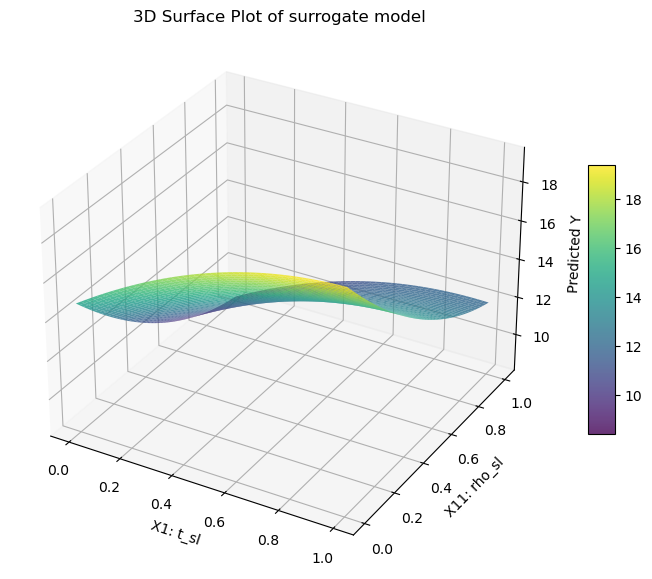

In [19]:
input_name = ['t_sl' ,'t_cor', 't_g', 't_ew', 't_iw',
              'e_sl' ,'e_cor', 'e_g', 'e_ew', 'e_iw',
              'rho_sl' ,'rho_cor', 'rho_g', 'rho_ew', 'rho_iw',
              'soil_vs' ,'soil_rho', 'heig', 'DampR']
visualizeSurrogate3D(gpr_fn1_ex220, 19, 0, 10,input_name = input_name)

### Sensitivity analysis

                ST   ST_conf
t_sl      0.200501  0.014716
t_cor     0.003042  0.000355
t_g       0.001220  0.000137
t_ew      0.050294  0.003886
t_iw      0.009216  0.000893
e_sl      0.147418  0.010509
e_cor     0.001269  0.000129
e_g       0.002137  0.000206
e_ew      0.028932  0.002430
e_iw      0.007785  0.000814
rho_sl    0.497567  0.031150
rho_cor   0.001707  0.000183
rho_g     0.001190  0.000157
rho_ew    0.001878  0.000262
rho_iw    0.001475  0.000169
soil_vs   0.045223  0.005105
soil_rho  0.014532  0.001538
heig      0.037515  0.002909
DampR     0.000995  0.000102
                S1   S1_conf
t_sl      0.177539  0.027017
t_cor     0.003567  0.003203
t_g       0.000338  0.001985
t_ew      0.049115  0.014140
t_iw      0.007540  0.006034
e_sl      0.139213  0.023734
e_cor    -0.000218  0.002192
e_g      -0.002191  0.002972
e_ew      0.023114  0.009150
e_iw      0.004373  0.005294
rho_sl    0.480305  0.041935
rho_cor   0.002058  0.002676
rho_g     0.000467  0.002021
rho_ew    0.00

C:\Users\v196m\AppData\Local\Temp\ipykernel_9196\2003193739.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


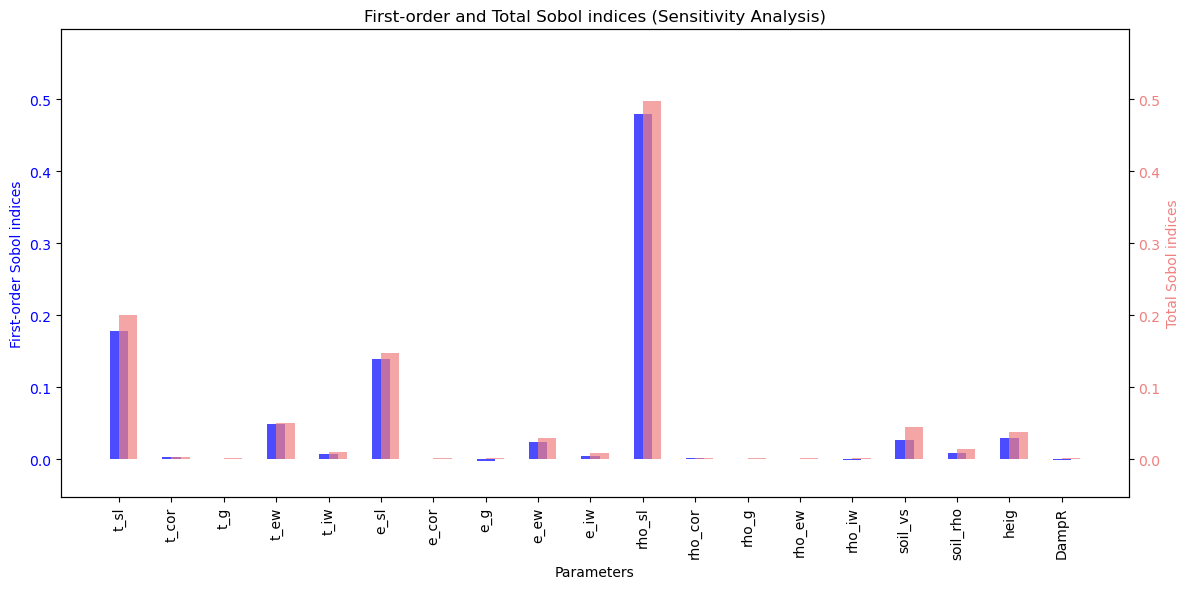

                ST   ST_conf
t_sl      0.524822  0.035058
t_cor     0.006155  0.000556
t_g       0.001010  0.000109
t_ew      0.011164  0.001034
t_iw      0.002961  0.000342
e_sl      0.188304  0.011825
e_cor     0.002148  0.000264
e_g       0.001156  0.000117
e_ew      0.003519  0.000380
e_iw      0.002323  0.000259
rho_sl    0.275556  0.017541
rho_cor   0.001534  0.000196
rho_g     0.001205  0.000146
rho_ew    0.003166  0.000407
rho_iw    0.002347  0.000285
soil_vs   0.002072  0.000235
soil_rho  0.001454  0.000176
heig      0.016069  0.001658
DampR     0.001783  0.000243
                S1   S1_conf
t_sl      0.504987  0.041723
t_cor     0.002237  0.004922
t_g       0.000567  0.001709
t_ew      0.006752  0.006616
t_iw      0.000069  0.003174
e_sl      0.171384  0.026705
e_cor     0.000650  0.002962
e_g      -0.000482  0.001651
e_ew      0.001918  0.003316
e_iw     -0.000669  0.002712
rho_sl    0.261966  0.032993
rho_cor  -0.000140  0.002331
rho_g    -0.000889  0.001996
rho_ew    0.00

C:\Users\v196m\AppData\Local\Temp\ipykernel_9196\2003193739.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


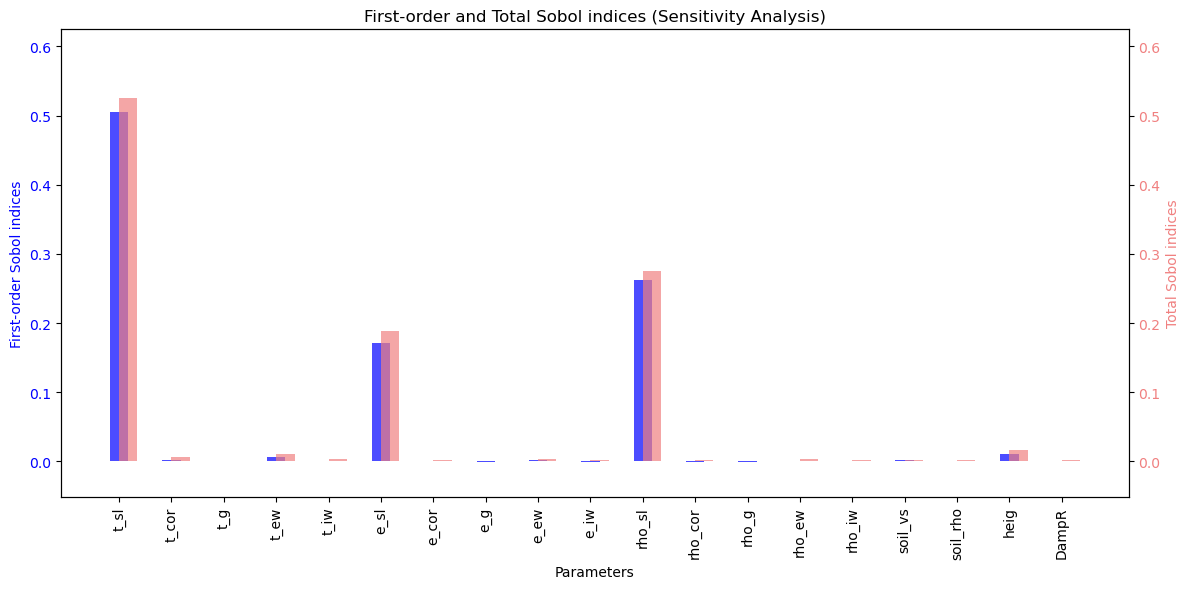

                ST   ST_conf
t_sl      0.176798  0.011887
t_cor     0.004052  0.000353
t_g       0.002110  0.000234
t_ew      0.051861  0.003109
t_iw      0.009209  0.000885
e_sl      0.152843  0.010371
e_cor     0.002126  0.000243
e_g       0.002522  0.000310
e_ew      0.033911  0.003199
e_iw      0.009045  0.000908
rho_sl    0.491483  0.030883
rho_cor   0.001829  0.000181
rho_g     0.001616  0.000183
rho_ew    0.003211  0.000353
rho_iw    0.001573  0.000148
soil_vs   0.043363  0.003973
soil_rho  0.014540  0.001589
heig      0.040980  0.002769
DampR     0.001501  0.000171
                S1   S1_conf
t_sl      0.154389  0.022279
t_cor     0.001633  0.004087
t_g       0.000729  0.003403
t_ew      0.050837  0.013084
t_iw      0.005366  0.005836
e_sl      0.144458  0.021483
e_cor     0.000055  0.003004
e_g       0.004078  0.003013
e_ew      0.026345  0.011259
e_iw      0.004879  0.007006
rho_sl    0.478328  0.039920
rho_cor   0.001937  0.002742
rho_g     0.000959  0.002309
rho_ew   -0.00

C:\Users\v196m\AppData\Local\Temp\ipykernel_9196\2003193739.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


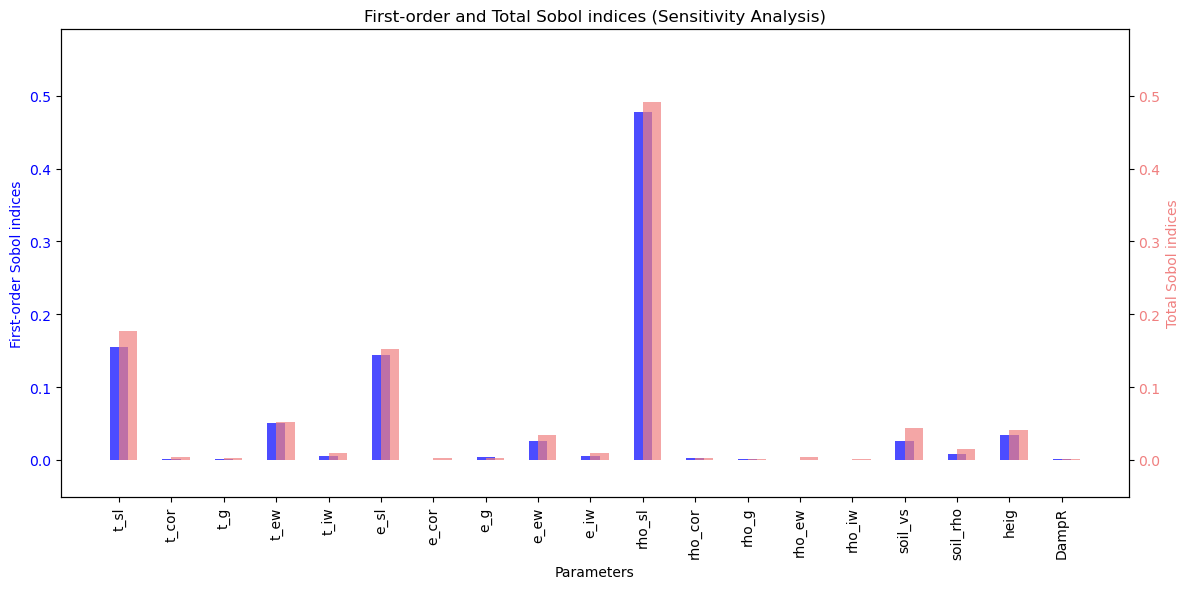

                ST   ST_conf
t_sl      0.421887  0.030565
t_cor     0.007102  0.000927
t_g       0.013559  0.001691
t_ew      0.036085  0.003888
t_iw      0.019364  0.002400
e_sl      0.210584  0.016940
e_cor     0.003720  0.000413
e_g       0.004005  0.000521
e_ew      0.005907  0.000659
e_iw      0.012402  0.001679
rho_sl    0.283469  0.021383
rho_cor   0.007597  0.001054
rho_g     0.007030  0.000848
rho_ew    0.006776  0.000815
rho_iw    0.007608  0.000961
soil_vs   0.009290  0.001161
soil_rho  0.009166  0.001020
heig      0.029001  0.003285
DampR     0.008293  0.000947
                S1   S1_conf
t_sl      0.383160  0.033289
t_cor     0.003841  0.005469
t_g       0.001363  0.007221
t_ew      0.021728  0.011431
t_iw      0.006655  0.007884
e_sl      0.194308  0.029761
e_cor     0.000502  0.003580
e_g      -0.001652  0.003959
e_ew      0.000752  0.004742
e_iw     -0.002822  0.006909
rho_sl    0.256187  0.030540
rho_cor  -0.001827  0.005447
rho_g     0.001428  0.005392
rho_ew    0.00

C:\Users\v196m\AppData\Local\Temp\ipykernel_9196\2003193739.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


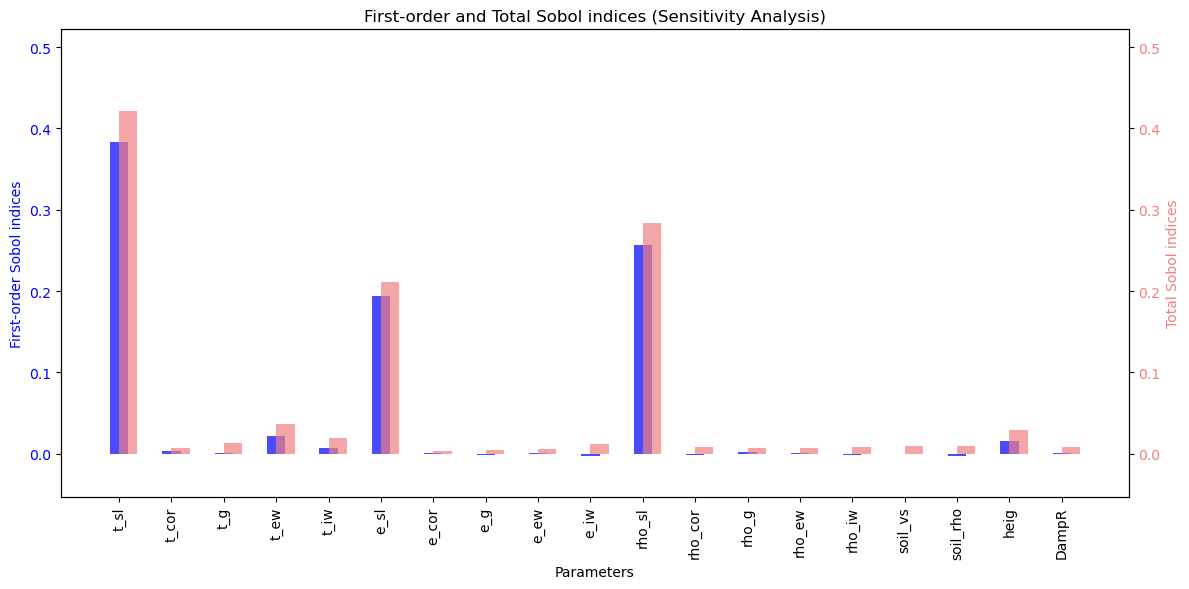

                ST   ST_conf
t_sl      0.187632  0.013535
t_cor     0.002925  0.000262
t_g       0.001169  0.000131
t_ew      0.048789  0.003478
t_iw      0.007921  0.000732
e_sl      0.156364  0.011702
e_cor     0.000963  0.000100
e_g       0.001326  0.000158
e_ew      0.030941  0.002616
e_iw      0.009649  0.000935
rho_sl    0.488050  0.030614
rho_cor   0.001522  0.000168
rho_g     0.001054  0.000126
rho_ew    0.002252  0.000275
rho_iw    0.001323  0.000144
soil_vs   0.047791  0.004318
soil_rho  0.015568  0.001713
heig      0.042607  0.003645
DampR     0.000958  0.000123
                S1   S1_conf
t_sl      0.167176  0.026297
t_cor     0.002122  0.003657
t_g       0.001357  0.002073
t_ew      0.047007  0.012612
t_iw      0.006748  0.005188
e_sl      0.145164  0.022626
e_cor    -0.000225  0.002132
e_g       0.002410  0.002547
e_ew      0.022758  0.010282
e_iw      0.007412  0.006595
rho_sl    0.477738  0.035656
rho_cor  -0.000132  0.002719
rho_g    -0.000215  0.002127
rho_ew    0.00

C:\Users\v196m\AppData\Local\Temp\ipykernel_9196\2003193739.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


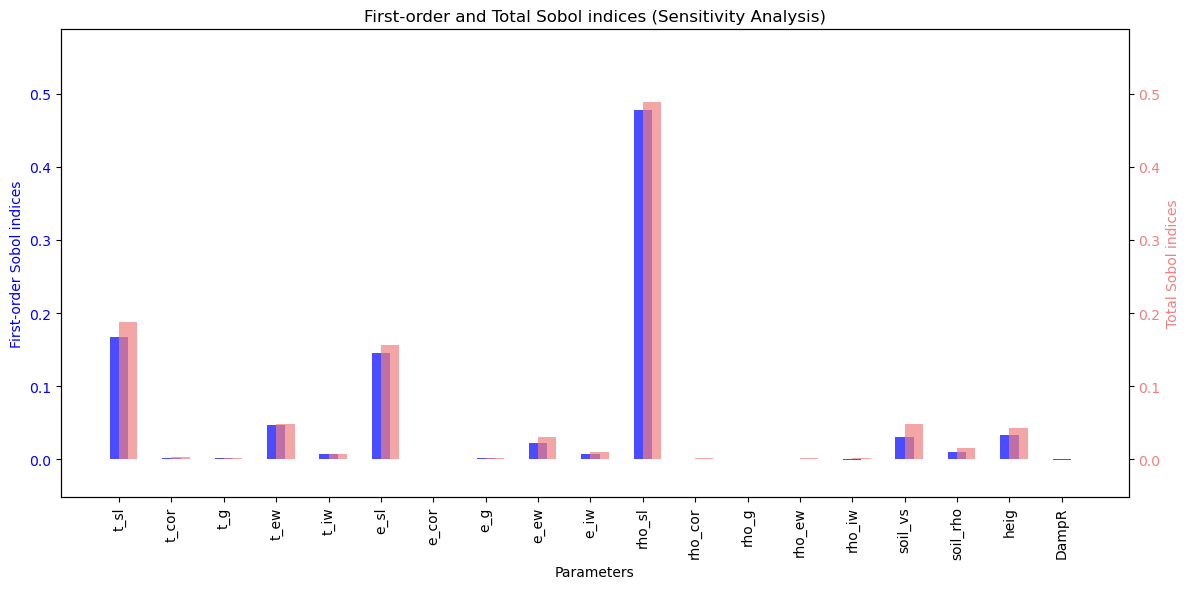

                ST   ST_conf
t_sl      0.485418  0.033854
t_cor     0.007597  0.000666
t_g       0.003093  0.000417
t_ew      0.015525  0.001277
t_iw      0.002743  0.000297
e_sl      0.180015  0.014749
e_cor     0.002241  0.000238
e_g       0.001975  0.000245
e_ew      0.004369  0.000464
e_iw      0.001761  0.000192
rho_sl    0.307842  0.020525
rho_cor   0.004405  0.000537
rho_g     0.002559  0.000343
rho_ew    0.003685  0.000436
rho_iw    0.001208  0.000123
soil_vs   0.002189  0.000264
soil_rho  0.002033  0.000220
heig      0.014447  0.001316
DampR     0.001852  0.000257
                S1   S1_conf
t_sl      0.463383  0.040200
t_cor     0.005044  0.005778
t_g       0.002087  0.003459
t_ew      0.014328  0.008235
t_iw     -0.001465  0.002877
e_sl      0.165273  0.025549
e_cor    -0.002023  0.002662
e_g      -0.001420  0.002794
e_ew      0.001959  0.003830
e_iw     -0.000087  0.002838
rho_sl    0.294238  0.037152
rho_cor   0.003486  0.004221
rho_g    -0.000742  0.003246
rho_ew    0.00

C:\Users\v196m\AppData\Local\Temp\ipykernel_9196\2003193739.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


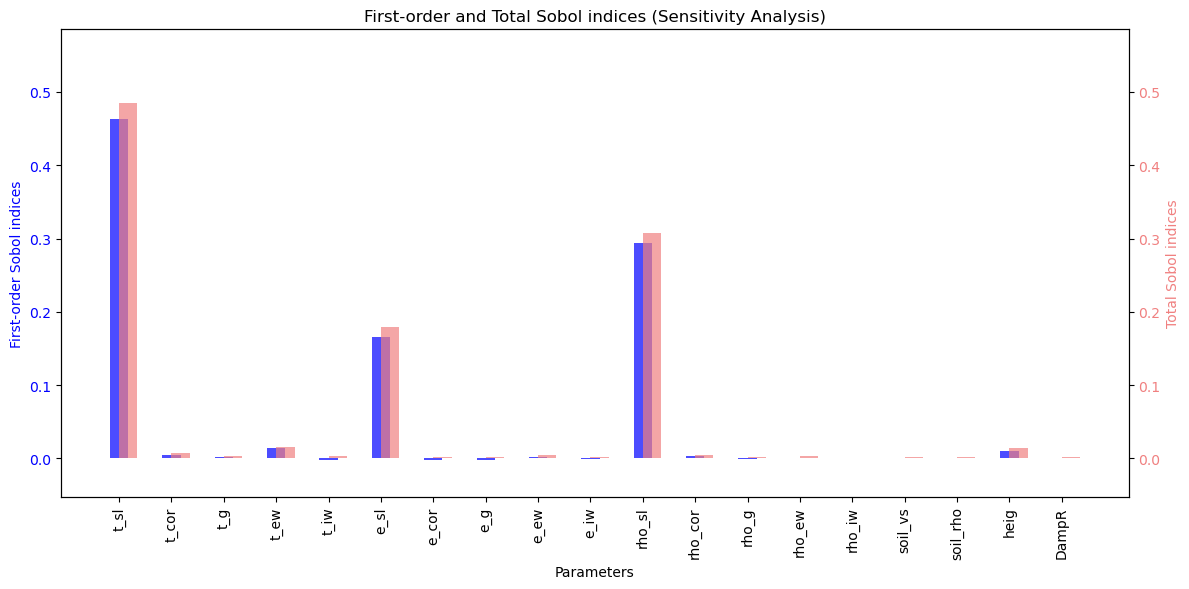

In [55]:
input_name = ['t_sl' ,'t_cor', 't_g', 't_ew', 't_iw',
              'e_sl' ,'e_cor', 'e_g', 'e_ew', 'e_iw',
              'rho_sl' ,'rho_cor', 'rho_g', 'rho_ew', 'rho_iw',
              'soil_vs' ,'soil_rho', 'heig', 'DampR']
Si_fn1_ex22 = sobol_GSA(gpr_fn1_ex22,19,2048,input_name,True)
Si_fn2_ex22 = sobol_GSA(gpr_fn2_ex22,19,2048,input_name,True)

Si_fn1_ex221 = sobol_GSA(gpr_fn1_ex221,19,2048,input_name,True)
Si_fn2_ex221 = sobol_GSA(gpr_fn2_ex221,19,2048,input_name,True)

Si_fn1_ex220 = sobol_GSA(gpr_fn1_ex220,19,2048,input_name,True)
Si_fn2_ex220 = sobol_GSA(gpr_fn2_ex220,19,2048,input_name,True)

### Optimization by GA

$x = argmin \sum_{i=1}^{3}(w_{1}^{i}*(f_{n1,gpr}^{i}-f_{n1,exp}^{i}))^2 + (w_{2}^{i}*(f_{n2,gpr}^{i}-f_{n2,exp}^{i}))^2 $ where $i$ indicates the index of impact tests.

$w_{1}^i = 100$ for $i = 1 \cdots 3$, 

$w_{2}^1 =  w_{2}^3 = 100$ and $w_{2}^2 = 50$ , 

In [46]:
import numpy as np
from scipy.optimize import minimize
from deap import base, creator, tools, algorithms
from scipy.stats import qmc

# Example surrogate models (replace with your actual GPR models)
def surrogate_fn1_ex22(inputs):
    
    # GPR model for fn1 (natural frequency 1)
    return gpr_fn1_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex22(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex221.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex221.predict(inputs.reshape(1, -1))[0]

# Objective function: minimize the difference from target
def objective_function(x_):
    #x = np.array(x)
    x = 0.5*np.ones(19)
    x[0] = x_[0]
    x[3] = x_[1]
    x[4] = x_[2]
    x[5] = x_[3]
    x[8] = x_[4]
    x[10] = x_[5]
    x[15] = x_[6]
    x[16] = x_[7]
    x[17] = x_[8]
    fn1_pred_ex22 = surrogate_fn1_ex22(x)
    fn2_pred_ex22 = surrogate_fn2_ex22(x)
    fn1_pred_ex220 = surrogate_fn1_ex220(x)
    fn2_pred_ex220 = surrogate_fn2_ex220(x)
    fn1_pred_ex221 = surrogate_fn1_ex221(x)
    fn2_pred_ex221 = surrogate_fn2_ex221(x)
    return ((100*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (100*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (100*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (100*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2 +(100*(fn1_pred_ex221 - mean_fn_1_exp_ex221))**2 + (100*(fn2_pred_ex221 - mean_fn_2_exp_ex221))**2,)


bounds = [(0, 1) for _ in range(9)]  # Example bounds

# Remaining significant parameter: 0,3,4,5,8,10,15,16,17
# Using correlation: 0,3,5,8,9,10,17,18
#bounds[0 ]  = (0,1)
#bounds[3 ]  = (0,1)
#bounds[4 ]  = (0,1)
#bounds[5 ]  = (0,1)
#bounds[8 ]  = (0,1)
#bounds[10] = (0,1)
#bounds[15] = (0,1)
#bounds[16] = (0,1)
bounds[8] = (0.3,0.7)

# Define parameter bounds (example: [(low1, high1), (low2, high2), ...])
#bounds = [(0, 10), (50, 100), (0.1, 1.0)]  # Example bounds for each parameter
num_params = len(bounds)
population_size = 4000  # Define population size

# Generate LHS samples
sampler = qmc.LatinHypercube(d=num_params)  # d = number of parameters
lhs_samples = sampler.random(n=population_size+1)  # Generate population_size samples
scaled_samples = qmc.scale(lhs_samples, [b[0] for b in bounds], [b[1] for b in bounds])  # Scale to bounds

# Custom parameter generator using LHS
lhs_population = scaled_samples.tolist()  # Convert to a list of lists
print(np.shape(lhs_population))
def generate_individual():
    """Populates from the pre-generated LHS samples."""
    if not lhs_population:
        raise ValueError("LHS population is exhausted! Increase the number of samples.")
    return lhs_population.pop(0)

# Define the fitness function (minimization problem)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, generate_individual)  # Individual generator
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # Population generator

# Register genetic operators
toolbox.register("evaluate", objective_function)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Population size and generations
population = toolbox.population(n=population_size)  # Population of 100 individuals

# Run the genetic algorithm
num_generations = 400
result_population, log = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=num_generations, 
                                             stats=None, halloffame=None, verbose=True)

# Evaluate all individuals and sort them
evaluated_population = [(ind, objective_function(ind)) for ind in result_population]
sorted_population = sorted(evaluated_population, key=lambda x: x[1])  # Sort by fitness

# Top 10 candidates
top_10_candidates = sorted_population[:30]

# Print the results
for idx, (candidate, score) in enumerate(top_10_candidates):
    print(f"Rank {idx+1}: Parameters = {candidate}, Objective = {score}")




(4001, 9)


c:\Users\v196m\anaconda3\envs\opt2\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\v196m\anaconda3\envs\opt2\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	4000  
1  	3052  
2  	3057  
3  	3047  
4  	3058  
5  	3033  
6  	3057  
7  	3033  
8  	3063  
9  	3004  
10 	3041  
11 	2986  
12 	3073  
13 	3002  
14 	3037  
15 	3001  
16 	3015  
17 	2971  
18 	3057  
19 	2957  
20 	3025  
21 	3109  
22 	3057  
23 	3055  
24 	3010  
25 	3084  
26 	3088  
27 	3010  
28 	3016  
29 	3022  
30 	3058  
31 	3021  
32 	3066  
33 	3080  
34 	2998  
35 	3076  
36 	3046  
37 	3050  
38 	3033  
39 	3025  
40 	2986  
41 	3048  
42 	2991  
43 	3032  
44 	3017  
45 	3089  
46 	3011  
47 	3010  
48 	3076  
49 	3046  
50 	2992  
51 	3031  
52 	3068  
53 	3054  
54 	3113  
55 	3022  
56 	3073  
57 	3004  
58 	2990  
59 	3072  
60 	3132  
61 	3047  
62 	3018  
63 	3028  
64 	3021  
65 	3064  
66 	3059  
67 	2996  
68 	2950  
69 	3095  
70 	3032  
71 	3075  
72 	2983  
73 	3063  
74 	3068  
75 	2978  
76 	3079  
77 	3061  
78 	3114  
79 	2988  
80 	3042  
81 	3039  
82 	3060  
83 	3108  
84 	3012  
85 	3098  
86 	3041  
87 	3034  
88 	3102  
89 	3067  

### OPtimization by L-BFGS-B

In [67]:
import numpy as np
from scipy.optimize import minimize

# Example surrogate models (replace with your actual GPR models)
def surrogate_fn1_ex22(inputs):
    # GPR model for fn1 (natural frequency 1)
    return gpr_fn1_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex22(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex221.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex221.predict(inputs.reshape(1, -1))[0]

# Objective function: minimize the difference from target
def objective_function(x):
    fn1_pred_ex22 = surrogate_fn1_ex22(x)
    fn2_pred_ex22 = surrogate_fn2_ex22(x)
    fn1_pred_ex220 = surrogate_fn1_ex220(x)
    fn2_pred_ex220 = surrogate_fn2_ex220(x)
    fn1_pred_ex221 = surrogate_fn1_ex221(x)
    fn2_pred_ex221 = surrogate_fn2_ex221(x)
    return (100*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (100*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (100*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (50*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2 +(1000*(fn1_pred_ex221 - mean_fn_1_exp_ex221))**2 + (1000*(fn2_pred_ex221 - mean_fn_2_exp_ex221))**2
    #return ((fn1_pred - 12.1344)**2) + ((fn2_pred - 18.8672)**2)
# 
# Bounds for the 19 parameters (adjust as per your problem)
bounds = [(0.35, 0.65) for _ in range(19)]  # Example bounds

bounds[0]  = (0,1)
bounds[3]  = (0,1)
bounds[4]  = (0,1)
bounds[5]  = (0,1)
bounds[8]  = (0,1)
bounds[10] = (0,1)
bounds[15] = (0,1)
bounds[16] = (0,1)
bounds[17] = (0,1)


# Initial guess for the parameters
#x0 = np.random.uniform(0, 1 ,size=19)
id_ = 0
x0 = 0.5*np.ones(19)


x0[0]  = top_10_candidates[id_][0][0]
x0[3]  = top_10_candidates[id_][0][1]
x0[4]  = top_10_candidates[id_][0][2]
x0[5]  = top_10_candidates[id_][0][3]
x0[8]  = top_10_candidates[id_][0][4]
x0[10] = top_10_candidates[id_][0][5]
x0[15] = top_10_candidates[id_][0][6]
x0[16] = top_10_candidates[id_][0][7]
x0[17] = top_10_candidates[id_][0][8]

#x0 = top_10_candidates[5][0]

x_top_10_candidates = np.zeros([10,19])
print(x0)

for i_top in range(1):
    # Perform optimization
    result = minimize(objective_function, x0, bounds=bounds, method='L-BFGS-B')

    # Optimized parameters
    if result.success:
        optimized_params = result.x
        print("Optimized Parameters:", optimized_params)
        print("Objective Function Value:", result.fun)
        print(f"goal fn_1:{mean_fn_1_exp_ex22}, fn_2:{mean_fn_2_exp_ex22}")
        print(f"fn_1: {surrogate_fn1_ex22(result.x)}, fn_2: {surrogate_fn2_ex22(result.x)}")
        print(f"goal fn_1:{mean_fn_1_exp_ex220}, fn_2:{mean_fn_2_exp_ex220}")
        print(f"fn_1: {surrogate_fn1_ex220(result.x)}, fn_2: {surrogate_fn2_ex220(result.x)}")
        print(f"goal fn_1:{mean_fn_1_exp_ex221}, fn_2:{mean_fn_2_exp_ex221}")
        print(f"fn_1: {surrogate_fn1_ex221(result.x)}, fn_2: {surrogate_fn2_ex221(result.x)}")
        x_top_10_candidates[i_top,:] = result.x
        
    else:
        print("Optimization failed:", result.message)

# Identify rows that are not all zeros
non_zero_rows = ~np.all(x_top_10_candidates == 0, axis=1)
# Remove rows with all zeros
x_top_10_candidates = x_top_10_candidates[non_zero_rows]
x_top_10_candidates = np.unique(x_top_10_candidates, axis=0)
print(x_top_10_candidates)


[0.83123572 0.5        0.5        0.34952338 0.26048403 0.7809106
 0.5        0.5        0.44974711 0.5        0.74582422 0.5
 0.5        0.5        0.5        0.19888445 0.25902777 0.09161728
 0.5       ]
Optimized Parameters: [0.81484659 0.46686521 0.5405732  0.48068243 0.2688561  0.81549055
 0.42925797 0.53702979 0.46147802 0.5422323  0.74408384 0.64249069
 0.52207918 0.38818366 0.40265408 0.12773497 0.31597417 0.19893539
 0.57906483]
Objective Function Value: 3.595706198322968e-06
goal fn_1:12.1344, fn_2:18.8672
fn_1: 12.134405581393224, fn_2: 18.86720546370185
goal fn_1:12.1856, fn_2:19.200000000000003
fn_1: 12.185584408758473, fn_2: 19.20001340242429
goal fn_1:12.2112, fn_2:18.8672
fn_1: 12.211200312567422, fn_2: 18.867200089651305
[[0.81484659 0.46686521 0.5405732  0.48068243 0.2688561  0.81549055
  0.42925797 0.53702979 0.46147802 0.5422323  0.74408384 0.64249069
  0.52207918 0.38818366 0.40265408 0.12773497 0.31597417 0.19893539
  0.57906483]]


In [ ]:
print(np.shape(x_top_10_candidates))
# Create subplots for the 8 histograms
fig, axes = plt.subplots(4, 5, figsize=(15, 8))  # 2 rows, 4 columns
axes = axes.flatten()  # Flatten to easily iterate
# Plot each histogram
for i in range(19):
    axes[i].hist((x_top_10_candidates[:, i]), bins=10, alpha=0.7, color='blue', edgecolor='black')
    axes[i].set_title(f"Histogram of var {i+1}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")
# Adjust layout
plt.tight_layout()
plt.show()

# Compute the correlation matrix
correlation_matrix = np.corrcoef(x_top_10_candidates, rowvar=False)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()

### Run the simulation for comparison the optmizaed result and expiremental data
- we might need futher optimization process for fine-tunning

In [65]:
simu_tk = simulation_PyAPDL(nproc=4,nerr=10000)
simu_tk.launch_engine()
simu_tk.mapdl.clear()

PyMAPDL is taking longer than expected to connect to an MAPDL session.
Checking if there are any available licenses...
Launch Pymapdl
     Launch Pymapdl successfully, duration 11.1709 seconds.


### Objecttive function for comparison with expirmental data

[[0.81484659 0.46686521 0.5405732  0.48068243 0.2688561  0.81549055
  0.42925797 0.53702979 0.46147802 0.5422323  0.74408384 0.64249069
  0.52207918 0.38818366 0.40265408 0.12773497 0.31597417 0.19893539
  0.57906483]]
 Setting information
     Building inner wall           :  True
     Building stair                :  True
     Building SSI                  :  True
     Element size                  :  0.4
     Height of building            :  2.3554122486028106
 Assigning parameter
     Rewrite thickness by input
     Rewrite Young's modulus by input
     Rewrite Poisson's ratio by input
     Rewrite Density by input
     Rewrite soil properties by input
 /PREP7 activated
     /PREP7 finished, duration 9.1836 seconds.
Solve model: /SOLU
 Setting information
     Solution type                 :  6
     Start frequency               :  0.001
     End frequency                 :  50
     Freqency increment            :  1
     Number of modes (solu_type=2) :  40
     Damping ratio      

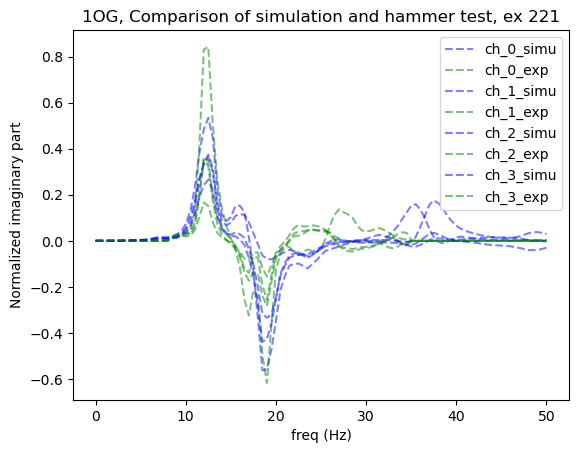

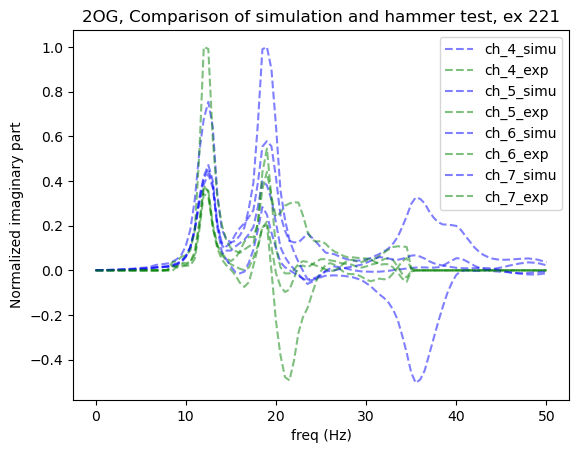

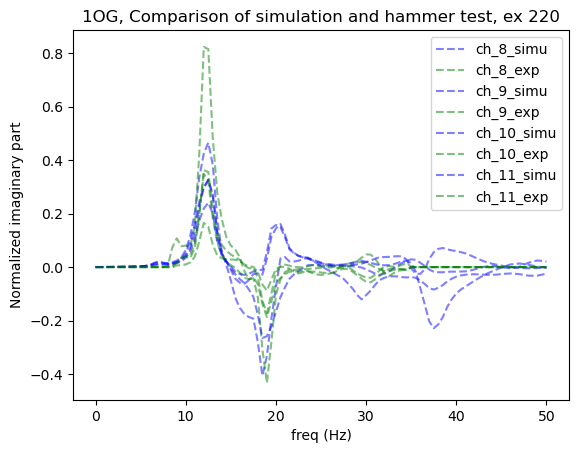

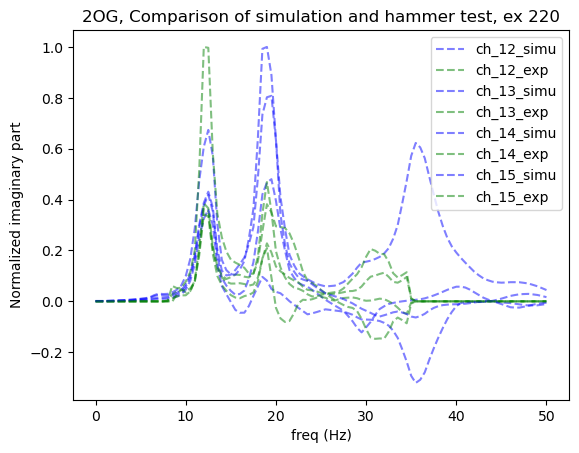

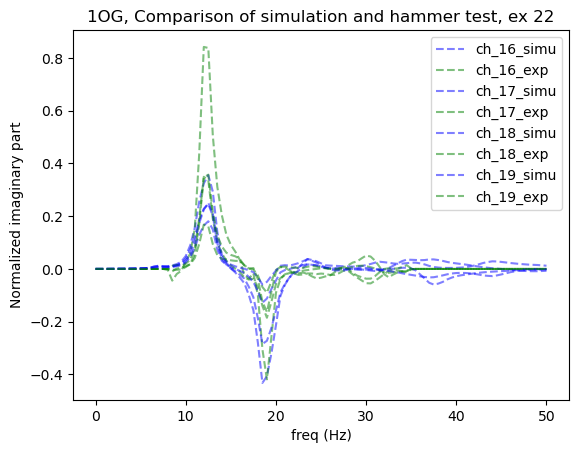

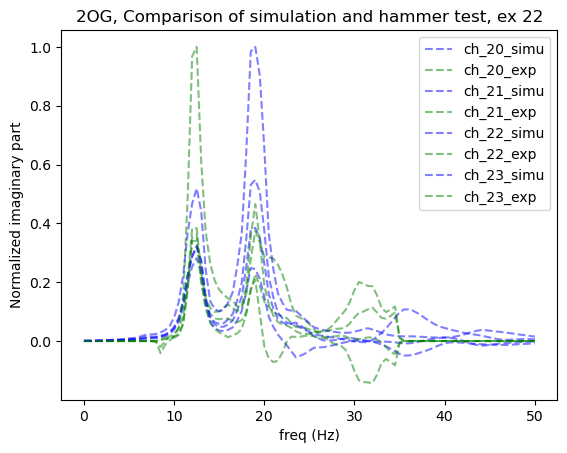

23.590480471603275


In [ ]:
import os
from IPython.display import clear_output


def objective_function(X_input):
    vary_ratio = 0.5
    X_transformed = 2 * X_input - 1
    X_transformed = X_transformed.reshape(-1,1)
    X_transformed = np.transpose(X_transformed)
    i_doe = 0
    X_doe_transformed = X_transformed
    #
    # Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
    # Parameter list    = [ vs,   rho,   nu ]
    t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                        0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                        0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                        0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
    #
    e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
    #
    nu_para  = np.array([ 0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27])
    #
    rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                        2300 + vary_ratio*2300*X_transformed[i_doe,11],
                        2300 + vary_ratio*2300*X_transformed[i_doe,12],
                        2300 + vary_ratio*2300*X_transformed[i_doe,13],
                        2300 + vary_ratio*2300*X_transformed[i_doe,14],
                        2300 + vary_ratio*2300*X_transformed[i_doe,10]])
    #
    soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                        1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                        0.33 ])
    #
    height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
    damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
    tol = 0.3
    #
    #
    # Start the simulation 
    simu_tk.mapdl.clear()
    simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.1 Pos1 (close to edge)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
    nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex221 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex221 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex221
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos2 (sensor)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
    nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex220 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex220 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex220
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos1 (shaker)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
    nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex22 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex22 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex22
        }
    #
    simu_tk.mapdl.clear()
    #clear_output(wait=True)
    #
    freq_resample = np.linspace(0, 50, 101)
    FRFs_simu = np.zeros([24,len(freq_resample)])
    #
    i_ch_index = 0
    ch_list = [9,10,11,12,3,13,14,15]
    # Case 221
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 220
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 22
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    #
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_simu)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_simu[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(group)
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_simu_norm = normalized_data
    #
    #
    ####################################################################################################################################################
    # Import measurement data
    FRFs_exp = np.zeros([24,len(freq_resample)])
    #
    i_pos_1OG = [9,10,11,12,3,13,14,15]
    cut_freq_low = 8
    cut_freq_high = 50
    #
    i_file = 9
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 35 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i,:] = i_resample
    #
    i_file = 1
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 35 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+8,:] = i_resample
    #
    i_file = 13
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 35 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+16,:] = i_resample
    #
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_exp)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_exp[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(group)
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_exp_norm = normalized_data
    #FRFs_exp_norm = FRFs_exp/np.max(np.abs(FRFs_exp))
    #
    #
    error = (FRFs_simu_norm - FRFs_exp_norm)**2
    error_percentage = np.sum(error)
    #
    for i in range(0,4):
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle="--",color='green', alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("1OG, Comparison of simulation and hammer test, ex 221")
    plt.show()
    for i in range(4,8):
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle="--",color='green', alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("2OG, Comparison of simulation and hammer test, ex 221")
    plt.show()
    for i in range(8,12):
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle="--",color='green', alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("1OG, Comparison of simulation and hammer test, ex 220")
    plt.show()
    for i in range(12,16):
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle="--",color='green', alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("2OG, Comparison of simulation and hammer test, ex 220")
    plt.show()
    for i in range(16,20):
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle="--",color='green', alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("1OG, Comparison of simulation and hammer test, ex 22")
    plt.show()
    for i in range(20,24):
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle="--",color='green', alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("2OG, Comparison of simulation and hammer test, ex 22")
    plt.show()

    print(error_percentage)

    return error_percentage



x_best1 =  [ 1.0,        0.5,       0.5,           0,         0.5,        0.68722604,
            0.5,        0.5,       0.69845997,    0,         0.85229155, 0.5,
            0.5,        0.5,       0.5,           0.5,       0.5,        0.6,
            0.59828352]

x_best2 = [ 0.88901592, 0.27044889, 0.28554261, 0.01408451, 0.27367161, 0.7319021,
            0.72747765, 0.41692908, 0.21476516, 0.25659874, 0.61753642, 0.7479544,
            0.7999774 , 0.40522151, 0.62167283, 0.75864746, 0.65032564, 0.5237532,
            0.66511448]

#x_best_RD = [0.83629052 0.44722008 0.56284155 0.46165459 0.30330304 0.8110846
#  0.45877398 0.52606213 0.45404988 0.54072992 0.76899581 0.65577164
#  0.51205693 0.37330226 0.40043779 0.15221861 0.34418797 0.2150634
#  0.60079022]

#x_best_RD_2 = [0.81484659 0.46686521 0.5405732  0.48068243 0.2688561  0.81549055
#  0.42925797 0.53702979 0.46147802 0.5422323  0.74408384 0.64249069
  #0.52207918 0.38818366 0.40265408 0.12773497 0.31597417 0.19893539
  #0.57906483]

x_best = x_best1
#x_best = np.array(x_best2)
# Transform X from [0,1] to [-1,1]
#X_transformed = 2 * result.x - 1
print(x_top_10_candidates)
freq_resample = np.linspace(0, 50, 101)
for i_top_para in range(np.shape(x_top_10_candidates)[0]):
    error_per = objective_function(x_top_10_candidates[i_top_para,:])
#    channel_1 = [0,1,2,3,8,9,10,11,16,17,18,19]
#    channel_2 = [4,5,6,7,12,13,14,15,20,21,22,23]
#
#    for i in range(12):
#        plt.plot(freq_resample,result[channel_1[i],:], label=f"ch_{i}",linestyle="--",color='blue', alpha=0.5)
#        plt.legend()
#        plt.xlabel("freq (Hz)")
#        plt.ylabel("Normalized Amplitude")
#    plt.show()
#    for i in range(12):
#        plt.plot(freq_resample,result[channel_2[i],:], label=f"ch_{i}",linestyle="--",color='green', alpha=0.5)
#        plt.legend()
#        plt.xlabel("freq (Hz)")
#        plt.ylabel("Normalized Amplitude")
#    plt.show()
    



### Using GP for further optimization

#### Objective function

In [4]:
import os
from IPython.display import clear_output


def objective_function(X_input):
    X_input = np.array(X_input)
    vary_ratio = 0.5
    X_transformed = 2 * X_input - 1
    X_transformed = X_transformed.reshape(-1,1)
    X_transformed = np.transpose(X_transformed)
    i_doe = 0
    X_doe_transformed = X_transformed
    #
    # Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
    # Parameter list    = [ vs,   rho,   nu ]
    t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                        0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                        0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                        0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
    #
    e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
    #
    nu_para  = np.array([ 0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27])
    #
    rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                        2300 + vary_ratio*2300*X_transformed[i_doe,11],
                        2300 + vary_ratio*2300*X_transformed[i_doe,12],
                        2300 + vary_ratio*2300*X_transformed[i_doe,13],
                        2300 + vary_ratio*2300*X_transformed[i_doe,14],
                        2300 + vary_ratio*2300*X_transformed[i_doe,10]])
    #
    soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                        1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                        0.33 ])
    #
    height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
    damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
    tol = 0.3
    #
    #
    # Start the simulation 
    simu_tk.mapdl.clear()
    simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.1 Pos1 (close to edge)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
    nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex221 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex221 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex221
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos2 (sensor)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
    nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex220 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex220 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex220
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos1 (shaker)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
    nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex22 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex22 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex22
        }
    #
    simu_tk.mapdl.clear()
    clear_output(wait=True)
    #
    freq_resample = np.linspace(0, 50, 101)
    FRFs_simu = np.zeros([24,len(freq_resample)])
    #
    i_ch_index = 0
    ch_list = [9,10,11,12,3,13,14,15]
    # Case 221
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 220
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 22
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    #
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_simu)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_simu[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(group)
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_simu_norm = normalized_data
    #
    #
    ####################################################################################################################################################
    # Import measurement data
    FRFs_exp = np.zeros([24,len(freq_resample)])
    #
    i_pos_1OG = [9,10,11,12,3,13,14,15]
    cut_freq_low = 8
    cut_freq_high = 50
    #
    i_file = 9
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 35 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i,:] = i_resample
    #
    i_file = 1
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 35 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+8,:] = i_resample
    #
    i_file = 13
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 35 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+16,:] = i_resample
    #
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_exp)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_exp[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(group)
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_exp_norm = normalized_data
    #FRFs_exp_norm = FRFs_exp/np.max(np.abs(FRFs_exp))
    #
    #
    error = (FRFs_simu_norm - FRFs_exp_norm)**2
    error_percentage = np.sum(error)
    
    return error_percentage

### GP optimization

Iteration 1051
Current Best Parameters: [0.6478559717188036, 0.7391775320612837, 0.20373186083668382, 0.13512129186620325, 0.3356977999844718, 0.9689576550071832, 0.40497285018169166, 0.008096135147334184, 0.5885880897361028, 0.34638525206025106, 0.5938350684225642, 0.4602430551939742, 0.18333813354127632, 0.3794329933767247, 0.42021847886144403, 0.3802211270127101, 0.05172615403695627, 0.5930160193191327, 0.3431929578479727]
Current Best Objective Value: 14.061406091503438
----------------------------------------
Best objective value: 14.061406091503438
Best parameters:
x1: 0.6479
x2: 0.7392
x3: 0.2037
x4: 0.1351
x5: 0.3357
x6: 0.9690
x7: 0.4050
x8: 0.0081
x9: 0.5886
x10: 0.3464
x11: 0.5938
x12: 0.4602
x13: 0.1833
x14: 0.3794
x15: 0.4202
x16: 0.3802
x17: 0.0517
x18: 0.5930
x19: 0.3432
[0.6478559717188036, 0.7391775320612837, 0.20373186083668382, 0.13512129186620325, 0.3356977999844718, 0.9689576550071832, 0.40497285018169166, 0.008096135147334184, 0.5885880897361028, 0.346385252060251

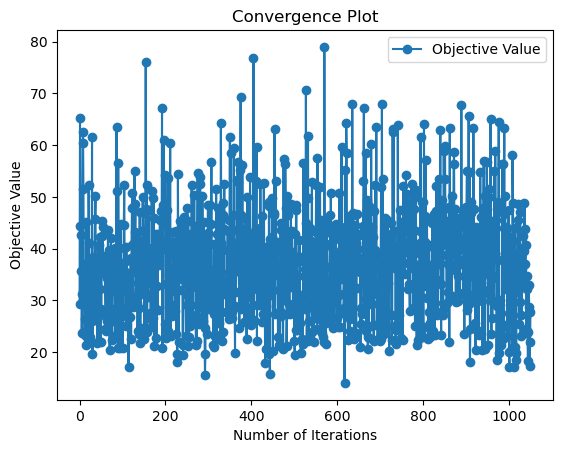

In [6]:
import numpy as np
from skopt import gp_minimize
from skopt import forest_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Initial guess
#initial_point_best = np.mean(x_top_10_candidates, axis=0)
initial_point_best = np.array([0.86163584, 0.59728558, 0.67887033, 0.3799163,  0.54705921, 0.68827147,
0.63660772, 0.39303398, 0.30927521, 0.4905672,  0.72109263, 0.52573776,
 0.67194132, 0.11590521, 0.51403692, 0.35758634, 0.3907657,  0.55461558,
 0.53289235])
# Create bounds by adding/subtracting 0.5 and clamping to [0, 1]
#bound = [(max(0, val - 0.25), min(1, val + 0.25)) for val in initial_point_best]
bound = [(0,1) for val in initial_point_best]
# Convert to skopt's Real dimensions for optimization
bounds = [Real(low, high, name=f"x{i}") for i, (low, high) in enumerate(bound)]
# Evaluate the objective function at these initial points
initial_values_best = objective_function(initial_point_best) 

## Also input the infromation from previous simulation
initial_points = np.vstack([X, initial_point_best])
initial_values = np.append(error_all, initial_values_best)

# Define a callback function to print the current state
def print_progress(res):
    print(f"Iteration {len(res.x_iters)}")
    print(f"Current Best Parameters: {res.x}")
    print(f"Current Best Objective Value: {res.fun}")
    print("-" * 40)

# Convert the objective function to use named arguments
@use_named_args(bounds)
def wrapped_objective(**params):
    return objective_function(list(params.values()))

# Run Gaussian Process Optimization
result = forest_minimize(
    func=wrapped_objective,
    dimensions=bounds,
    n_calls=50,  # Total evaluations, including initial points
    n_initial_points=0,    
    x0=initial_points.tolist(),
    y0=initial_values.tolist(),
    random_state=42,
    callback=[print_progress]
)

# Display the results
print("Best objective value:", result.fun)
print("Best parameters:")
for i, param in enumerate(result.x):
    print(f"x{i+1}: {param:.4f}")
print(result.x)

# Visualize progress of the optimization
import matplotlib.pyplot as plt
plt.plot(result.func_vals, marker='o', label="Objective Value")
plt.xlabel("Number of Iterations")
plt.ylabel("Objective Value")
plt.title("Convergence Plot")
plt.legend()
plt.show()


START
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Best parameter set: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Best objective value: 0.0


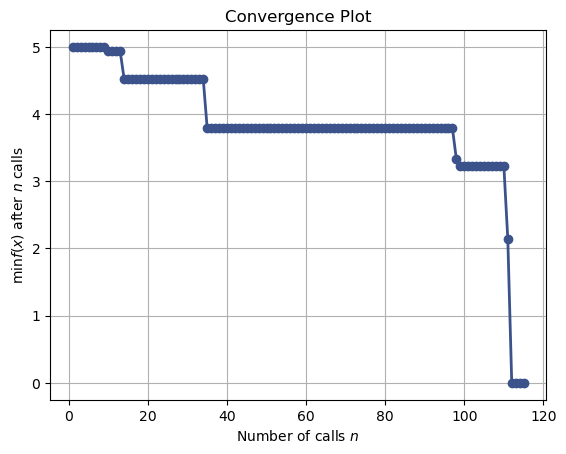

In [23]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Define the search space for 19 parameters
search_space = [Real(0, 1, name=f"x{i}") for i in range(19)]

# Define the objective function
def objective_function_1(params):
    # Example objective function: sum of squares
    # Replace this with your actual function
    return sum(value ** 2 for value in params)

# Define the objective function
def objective_function(params):
    # Example objective function: sum of squares
    # Replace this with your actual function
    print("1")
    return sum(value ** 2 for value in params)

# Initial guesses (1000 samples with 19 dimensions)
initial_guesses = np.random.uniform(0, 1, size=(100, 19))  # Replace with your actual initial data
initial_evaluations = np.array([objective_function_1(sample) for sample in initial_guesses])  # Evaluate objective

print("START")
# Use gp_minimize with your existing initial guesses
result = gp_minimize(
    func=objective_function,  # Objective function to minimize
    dimensions=search_space,  # Search space
    n_calls=15,              # Total calls (including initial guesses)
    #n_initial_points=0,       # Skip default random initialization
    x0=initial_guesses.tolist(),  # Use your initial guesses
    y0=initial_evaluations.tolist(),  # Provide results of initial guesses
    random_state=42           # Set a seed for reproducibility
)

# Print the best result
print("Best parameter set:", result.x)
print("Best objective value:", result.fun)

# Visualize convergence
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt

plot_convergence(result)
plt.title("Convergence Plot")
plt.show()



### Validation from L-BFGS-B

In [ ]:
import os
from IPython.display import clear_output

DOE_info = {}
vary_ratio = 0.5

x_best1 =  [ 1.0,        0.5,       0.5,           0,         0.5,        0.68722604,
            0.5,        0.5,       0.69845997,    0,         0.85229155, 0.5,
            0.5,        0.5,       0.5,           0.5,       0.5,        0.6,
            0.59828352]

x_best2 = [ 0.88901592, 0.27044889, 0.28554261, 0.01408451, 0.27367161, 0.7319021,
            0.72747765, 0.41692908, 0.21476516, 0.25659874, 0.61753642, 0.7479544,
            0.7999774 , 0.40522151, 0.62167283, 0.75864746, 0.65032564, 0.5237532,
            0.66511448]

x_oriignal = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

x_best = result.x
x_best = np.array(x_best)
# Transform X from [0,1] to [-1,1]
#X_transformed = 2 * result.x - 1
X_transformed = 2 * x_best - 1
X_transformed = X_transformed.reshape(-1,1)
X_transformed = np.transpose(X_transformed)
i_doe = 0
X_doe_transformed = X_transformed

# Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
# Parameter list    = [ vs,   rho,   nu ]
t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                      0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                      0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                      0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                      0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                      0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
#
e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
#
nu_para  = np.array([ 0.27,
                      0.27,
                      0.27,
                      0.27,
                      0.27,
                      0.27])
#
rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                      2300 + vary_ratio*2300*X_transformed[i_doe,11],
                      2300 + vary_ratio*2300*X_transformed[i_doe,12],
                      2300 + vary_ratio*2300*X_transformed[i_doe,13],
                      2300 + vary_ratio*2300*X_transformed[i_doe,14],
                      2300 + vary_ratio*2300*X_transformed[i_doe,10]])
#
soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                       1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                       0.33 ])
#
height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
tol = 0.3

# Start the simulation 
simu_tk.mapdl.clear()
simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
simu_tk.build_model()
# Excitation point: Hammer 2.1 Pos1 (close to edge)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
simu_tk.mapdl.nsel('ALL')
# Apply the force on selected node and solve 
simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[1])
modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
## Get FRF at target point
meas_FRFs_ex221 = simu_tk.get_FRFs_meas_EXAMPLE()
DOE_info_ex221 = {
    'id':i_doe,
    'X':x_best.tolist(),
    'X_trans':X_doe_transformed.tolist(),
    't_info':simu_tk.t_arr.tolist(),
    'e_info':simu_tk.e_arr.tolist(),
    'n_info':simu_tk.nu_arr.tolist(),
    'r_info':simu_tk.rho_arr.tolist(),
    's_info':simu_tk.soil_arr.tolist(),
    'height':simu_tk.height,
    'dr':simu_tk.Damping_ratio,
    'modal_info':modal_info,
    'meas_frf':meas_FRFs_ex221
    }
simu_tk.mapdl.clear()



simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
simu_tk.build_model()
# Excitation point: Hammer 2.0 Pos2 (sensor)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
simu_tk.mapdl.nsel('ALL')
# Apply the force on selected node and solve 
simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
## Get FRF at target point
meas_FRFs_ex220 = simu_tk.get_FRFs_meas_EXAMPLE()
DOE_info_ex220 = {
    'id':i_doe,
    'X':x_best.tolist(),
    'X_trans':X_doe_transformed.tolist(),
    't_info':simu_tk.t_arr.tolist(),
    'e_info':simu_tk.e_arr.tolist(),
    'n_info':simu_tk.nu_arr.tolist(),
    'r_info':simu_tk.rho_arr.tolist(),
    's_info':simu_tk.soil_arr.tolist(),
    'height':simu_tk.height,
    'dr':simu_tk.Damping_ratio,
    'modal_info':modal_info,
    'meas_frf':meas_FRFs_ex220
    }
simu_tk.mapdl.clear()



simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
simu_tk.build_model()
# Excitation point: Hammer 2.0 Pos1 (shaker)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
simu_tk.mapdl.nsel('ALL')
# Apply the force on selected node and solve 
simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
## Get FRF at target point
meas_FRFs_ex22 = simu_tk.get_FRFs_meas_EXAMPLE()
DOE_info_ex22 = {
    'id':i_doe,
    'X':x_best.tolist(),
    'X_trans':X_doe_transformed.tolist(),
    't_info':simu_tk.t_arr.tolist(),
    'e_info':simu_tk.e_arr.tolist(),
    'n_info':simu_tk.nu_arr.tolist(),
    'r_info':simu_tk.rho_arr.tolist(),
    's_info':simu_tk.soil_arr.tolist(),
    'height':simu_tk.height,
    'dr':simu_tk.Damping_ratio,
    'modal_info':modal_info,
    'meas_frf':meas_FRFs_ex22
    }

simu_tk.mapdl.clear()
clear_output(wait=True)

print(DOE_info_ex22['t_info'])
print(DOE_info_ex22['e_info'])
print(DOE_info_ex22['r_info'])
print(DOE_info_ex22['s_info'])
print(DOE_info_ex22['height'])
print(DOE_info_ex22['dr'])




[0.6632990150757021, 0.7646597452042387, 0.06852914808679007, 0.2243387362419274, 0.21227322837683468, 0.6632990150757021]
[24866670037.425358, 14069903427.108562, 15118812206.673473, 14478374507.751648, 14411608541.752113, 24866670037.425358]
[2900.1015192234768, 1642.3643720801406, 2247.187131618274, 1263.6499401990402, 2297.5135271262443, 2900.1015192234768]
[337.2455869736925, 1481.67516957959, 0.33]
4.117806389740481
0.03989201026674582


### Visualization

### Excitation 221, compare to exp 9

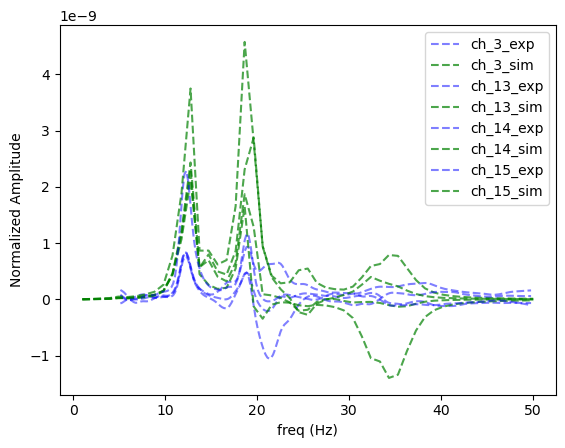

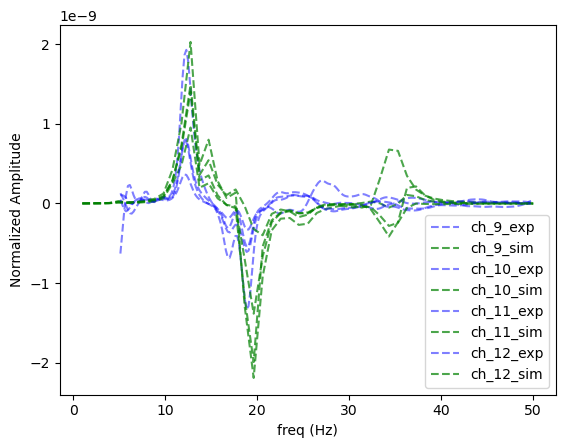

[12.4474821 12.4474821 12.4474821 12.4474821 12.4474821 12.4474821
 12.4474821 12.4474821]
12.4474821 19.170604566666665 0.7333092238744306 0.5831207121191299


In [ ]:
i_file = 9
#i_pos = 3
i_pos_1OG = [3,13,14,15]
cut_freq_low = 5
cut_freq_high = 50

f_1OG  = []
r_1OG  = []
i_1OG  = []


for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}_exp",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex221[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex221[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}_sim",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()


i_pos_1OG = [9,10,11,12]
f_1OG  = []
r_1OG  = []
i_1OG  = []
for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}_exp",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex221[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex221[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}_sim",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()

directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,2]
mode_2_exp = mode_shape_vector_exp[1::2,2]

ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
loaded_data = DOE_info_ex221
#
for i_ch in ch_list:
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
#
meas_FRFs = loaded_data['meas_frf']
#
natrual_freq = []
for i_mode in range(1,len(loaded_data['modal_info'])):
    natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
#
mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
#print(mode_freq_vector, mode_shape_vector)
#
i_ch_disp = [9,10,11,12,3,13,14,15]

mode_freq_1_list = np.zeros(len(i_ch_disp))
mode_freq_2_list = np.zeros(len(i_ch_disp))
mac_1_list = np.zeros(len(i_ch_disp))
mac_2_list = np.zeros(len(i_ch_disp))
#
#
for i_ch in range(len(i_ch_disp)):
#
    [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05)
    mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
    mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
#
f_n_1_mean = mean_value_filted(mode_freq_1_list,1)
f_n_2_mean = mean_value_filted(mode_freq_2_list,1)
mac_1_mean = mean_value_filted(mac_1_list,1)
mac_2_mean = mean_value_filted(mac_2_list,1)
print(mode_freq_1_list)


print(f_n_1_mean,f_n_2_mean,mac_1_mean,mac_2_mean )

### Excitation 220, compare to exp 1

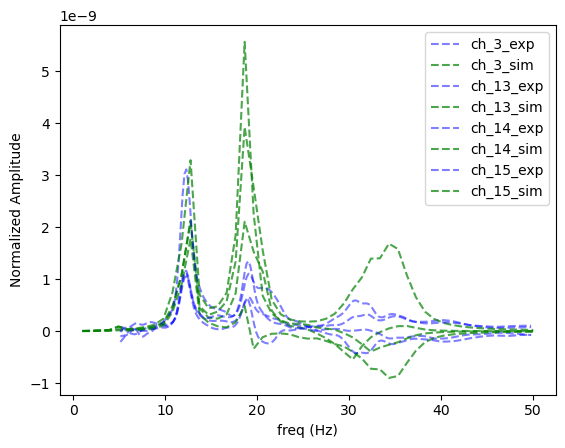

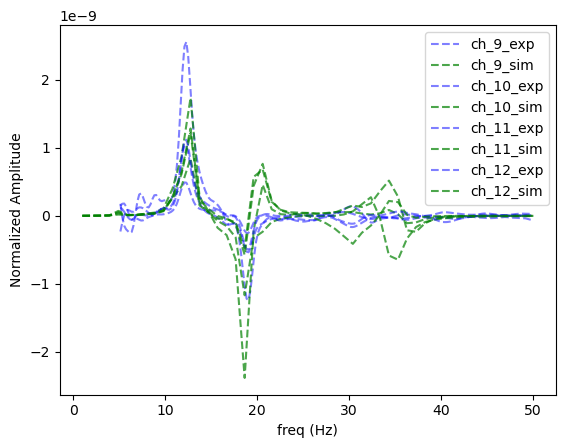

12.4474821 19.11582741428571 0.7287120594310318 0.565301851258544


In [ ]:
i_file = 1
#i_pos = 3
i_pos_1OG = [3,13,14,15]
cut_freq_low = 5
cut_freq_high = 50

f_1OG  = []
r_1OG  = []
i_1OG  = []

for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}_exp",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex220[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex220[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}_sim",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()


i_pos_1OG = [9,10,11,12]
f_1OG  = []
r_1OG  = []
i_1OG  = []
for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}_exp",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex220[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex220[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}_sim",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()

directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,2]
mode_2_exp = mode_shape_vector_exp[1::2,2]

ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
loaded_data = DOE_info_ex220
#
for i_ch in ch_list:
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
#
meas_FRFs_e = loaded_data['meas_frf']
#
natrual_freq = []
for i_mode in range(1,len(loaded_data['modal_info'])):
    natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
#
mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
#print(mode_freq_vector, mode_shape_vector)
#
mode_freq_1_list = np.zeros(8)
mode_freq_2_list = np.zeros(8)
mac_1_list = np.zeros(8)
mac_2_list = np.zeros(8)
#
i_ch_disp = [9,10,11,12,3,13,14,15]
for i_ch in range(8):
#
    [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['ampl']),0.05)
    mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
    mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
#
f_n_1_mean = mean_value_filted(mode_freq_1_list,1)
f_n_2_mean = mean_value_filted(mode_freq_2_list,1)
mac_1_mean = mean_value_filted(mac_1_list,1)
mac_2_mean = mean_value_filted(mac_2_list,1)


print(f_n_1_mean,f_n_2_mean,mac_1_mean,mac_2_mean )

Exictation 22, compare to exp 13

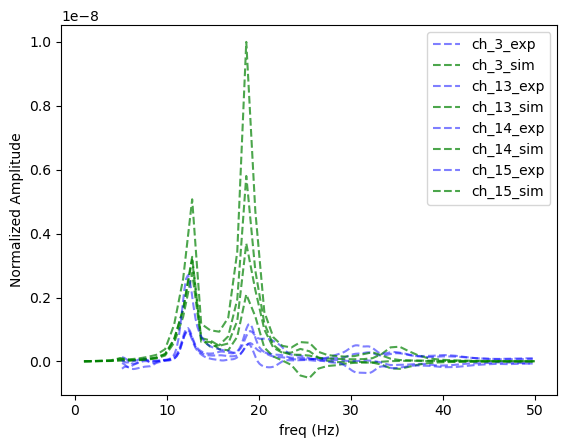

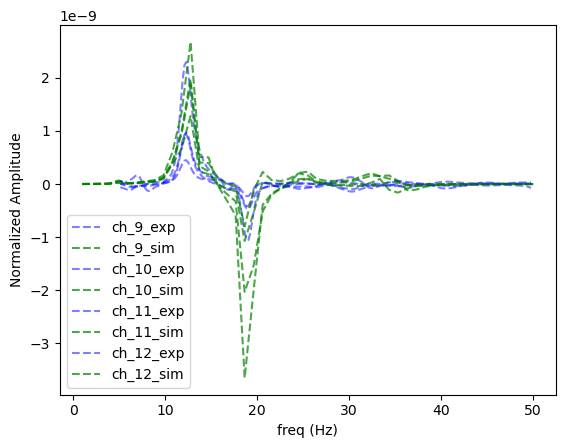

12.4474821 18.7871645 0.6160523020339247 0.6313607029682916


In [ ]:
i_file = 13
#i_pos = 3
i_pos_1OG = [3,13,14,15]
cut_freq_low = 5
cut_freq_high = 50

f_1OG  = []
r_1OG  = []
i_1OG  = []

for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}_exp",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex22[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex22[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}_sim",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()


i_pos_1OG = [9,10,11,12]
f_1OG  = []
r_1OG  = []
i_1OG  = []
for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}_exp",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex22[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex22[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}_sim",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()


directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,2]
mode_2_exp = mode_shape_vector_exp[1::2,2]

ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
loaded_data = DOE_info_ex22
#
for i_ch in ch_list:
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
#
meas_FRFs = loaded_data['meas_frf']
#
natrual_freq = []
for i_mode in range(1,len(loaded_data['modal_info'])):
    natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
#
mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
#print(mode_freq_vector, mode_shape_vector)
#
mode_freq_1_list = np.zeros(8)
mode_freq_2_list = np.zeros(8)
mac_1_list = np.zeros(8)
mac_2_list = np.zeros(8)
#
i_ch_disp = [9,10,11,12,3,13,14,15]
for i_ch in range(8):
#
    [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05)
    mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
    mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
#
f_n_1_mean = mean_value_filted(mode_freq_1_list,1)
f_n_2_mean = mean_value_filted(mode_freq_2_list,1)
mac_1_mean = mean_value_filted(mac_1_list,1)
mac_2_mean = mean_value_filted(mac_2_list,1)


print(f_n_1_mean,f_n_2_mean,mac_1_mean,mac_2_mean )